**I.Mount drive**

In [77]:
#If you do not use google colab, do not run 2 row code below, skip it
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


**II.Import library**

In [2]:
import os
import glob2
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, DepthwiseConv2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
from sklearn.model_selection import train_test_split
import requests
import matplotlib.pyplot as plt

**III.Clone data**

In [10]:
#If you have data, do not run the code below
#!git clone https://github.com/phamdinhkhanh/khanhBlogTurtorial.git /content/drive/MyDrive/Mini_Project/4_MultitaskLearning_fashion_classification/Data_fashion

Cloning into '/content/drive/MyDrive/Mini_Project/4_MultitaskLearning_fashion_classification/Data_fashion'...
remote: Enumerating objects: 3815, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 3815 (delta 27), reused 326 (delta 7), pack-reused 3451
Receiving objects: 100% (3815/3815), 548.83 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Updating files: 100% (4041/4041), done.


**IV.Visualize data**

In [14]:
def _list_images(root_dir, exts = ['.jpg', '.jpeg', '.png']):
  list_images = glob2.glob('/content/drive/MyDrive/Mini_Project/4_MultitaskLearning_fashion_classification/Data_fashion/Bai34-multitaskLearning'+'/**')
  image_links = []
  for image_link in list_images:
    for ext in exts:
      if ext in image_link[-5:]:
        image_links.append(image_link)
  return image_links

In [34]:
imagePath = sorted(_list_images(root_dir='Bai34-multitaskLearning'))
imagePaths = []
lst = [1879, 1880, 1881, 1882, 1883]
for i in range(len(imagePath)):
  if i in lst:
    continue
  imagePaths.append(imagePath[i])
  
labels = []
for path in imagePaths:
  if path.split("/")[-2] == "Bai34-multitaskLearning" or path.split("/")[-2] == "examples":
    continue
  labels.append(path.split("/")[-2])

<Axes: xlabel='label'>

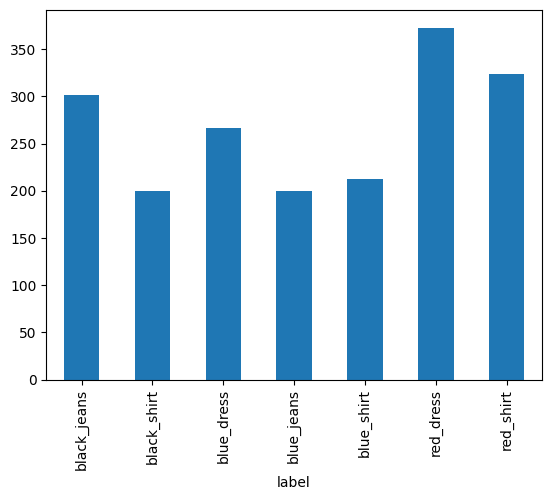

In [35]:
data = pd.DataFrame({'label': labels, 'source': imagePaths})
data.groupby('label').source.count().plot.bar()

**V.Build model**

In [42]:
INPUT_SHAPE = (96, 96, 3)
N_CLASSES = 6
class TuanNet(object):
  @staticmethod
  def build_model(inputShape = INPUT_SHAPE, classes = N_CLASSES, finAct = 'softmax'):
    inpt = Input(shape=inputShape)
    x = Conv2D(filters=32, kernel_size=(3, 3), 
              padding="same", activation='relu')(inpt)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
          activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    
    x = Flatten()(x)
    x = Dense(1048, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Activation("relu")(x)

    
    x = Dense(classes)(x)
    x = Activation(finAct, name="fashion_output")(x)
    model = Model(inputs=[inpt], outputs=[x])
    return model

In [43]:
model = TuanNet.build_model(inputShape=INPUT_SHAPE, classes=N_CLASSES,  finAct='sigmoid')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0   

**VI.Prepare and processing data**

In [45]:
image_aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2,
	                       horizontal_flip=True, fill_mode="nearest")

In [50]:
LR_RATE = 0.01
EPOCHS = 50
opt = tf.keras.optimizers.legacy.Adam(learning_rate=LR_RATE, decay=LR_RATE / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [57]:
images = []
labels = []
data_sources = data.groupby("label").source.apply(lambda x: list(x))
for i, sources in enumerate(data_sources):
  np.random.shuffle(list(sources))
  label = data_sources.index[i]
  sources = data_sources[label]
  for imagePath in sources:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, INPUT_SHAPE[:2])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    images.append(image)
    fashion, color = label.split("_")
    labels.append([fashion, color])

images = np.stack(images)
images = images / 255.0

In [59]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

In [1]:
#you should run the code below to save model
# f = open('/content/drive/MyDrive/Mini_Project/4_MultitaskLearning_fashion_classification/mlb.pkl', "wb")
# f.write(pickle.dumps(mlb))
# f.close()

In [62]:
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size = 0.2, random_state = 1)


In [63]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1503, 96, 96, 3), (1503, 6), (376, 96, 96, 3), (376, 6))

**VII.Training model**

In [64]:
BATCH_SIZE = 32
history = model.fit(image_aug.flow(X_train, y_train, batch_size = BATCH_SIZE),
                    validation_data = (X_val, y_val),
                    steps_per_epoch = len(X_train) // BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1)


Epoch 1/50
46/46 [==============================] - 136s 3s/step - loss: 8.6974 - accuracy: 0.5269 - val_loss: 1101.0688 - val_accuracy: 0.2394
Epoch 2/50
46/46 [==============================] - 125s 3s/step - loss: 2.1158 - accuracy: 0.6200 - val_loss: 73.4950 - val_accuracy: 0.3245
Epoch 3/50
46/46 [==============================] - 127s 3s/step - loss: 0.5785 - accuracy: 0.7131 - val_loss: 2.3165 - val_accuracy: 0.4840
Epoch 4/50
46/46 [==============================] - 123s 3s/step - loss: 0.3838 - accuracy: 0.7233 - val_loss: 1.1658 - val_accuracy: 0.5080
Epoch 5/50
46/46 [==============================] - 134s 3s/step - loss: 0.3262 - accuracy: 0.7199 - val_loss: 0.3057 - val_accuracy: 0.5878
Epoch 6/50
46/46 [==============================] - 123s 3s/step - loss: 0.2593 - accuracy: 0.6723 - val_loss: 0.1736 - val_accuracy: 0.6729
Epoch 7/50
46/46 [==============================] - 121s 3s/step - loss: 0.2542 - accuracy: 0.6785 - val_loss: 0.1431 - val_accuracy: 0.7048
Epoch 8/5

In [66]:
#you should run the code below to save model
#model.save("/content/drive/MyDrive/Mini_Project/4_MultitaskLearning_fashion_classification/model_fashion_multitask_learning.h5")

**VIII.Evaluate model**

In [67]:
model.evaluate(X_val, y_val, batch_size=32, use_multiprocessing=True)

12/12 [==============================] - 9s 735ms/step - loss: 0.0526 - accuracy: 0.7633


[0.05257830768823624, 0.7632978558540344]

**IX.Predict**

In [69]:
def _downloadImage(url):
  resp = requests.get(url)
  img = np.asarray(bytearray(resp.content), dtype="uint8")
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

In [70]:
def _predict_image(image, model, mlb):
  # Lấy kích thước 3 kênh của image
  (w, h, c) = image.shape
  # Nếu resize width = 400 thì height resize sẽ là
  height_rz = int(h*400/w)
  # Resize lại ảnh để hiện thị 
  output = cv2.resize(image, (height_rz, 400))
  # Resize lại ảnh để dự báo
  image = cv2.resize(image, IMAGE_DIMS[:2])/255.0
  # Dự báo xác suất của ảnh
  prob = model.predict(np.expand_dims(image, axis=0))[0]
  # Trích ra 2 xác suất cao nhất
  argmax = np.argsort(prob)[::-1][:2]
  # Show classes và probability ra ảnh hiển thị
  for (i, j) in enumerate(argmax):
    # popup nhãn và xác suất dự báo lên ảnh hiển thị
    label = "{}: {:.2f}%".format(mlb.classes_[j], prob[j] * 100)
    cv2.putText(output, label, (5, (i * 20) + 15), 
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (225, 0, 0), 2)
  # Hiển thị ảnh dự báo
  plt.figure(figsize=(8, 16))
  plt.axis('Off')
  plt.imshow(output)

1/1 [==============================] - 0s 397ms/step


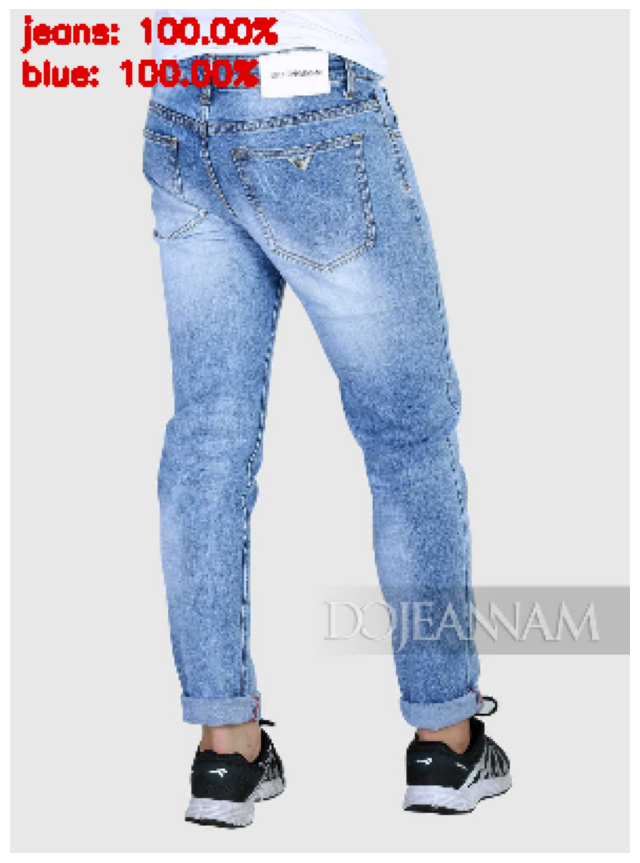

In [72]:
url = 'https://dojeannam.com/wp-content/uploads/2017/07/qu%E1%BA%A7n-jean-nam-wash-b%E1%BA%A1c-tr%E1%BA%AFng-sau.jpg'  
IMAGE_DIMS = (96, 96, 3)

image = _downloadImage(url)
_predict_image(image, model, mlb)

1/1 [==============================] - 0s 221ms/step


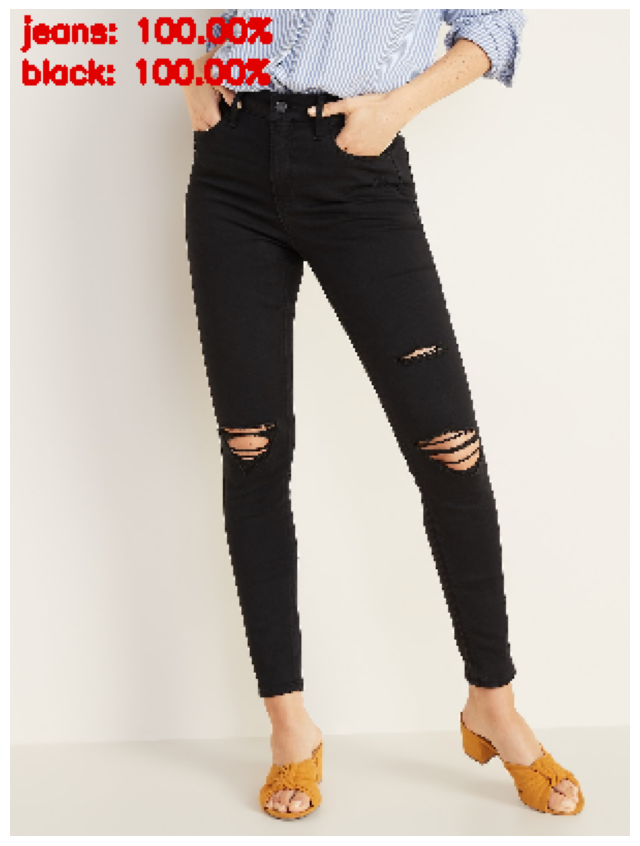

In [73]:
url = 'https://oldnavy.gap.com/webcontent/0017/191/832/cn17191832.jpg'  
IMAGE_DIMS = (96, 96, 3)

image = _downloadImage(url)
_predict_image(image, model, mlb)

1/1 [==============================] - 0s 79ms/step


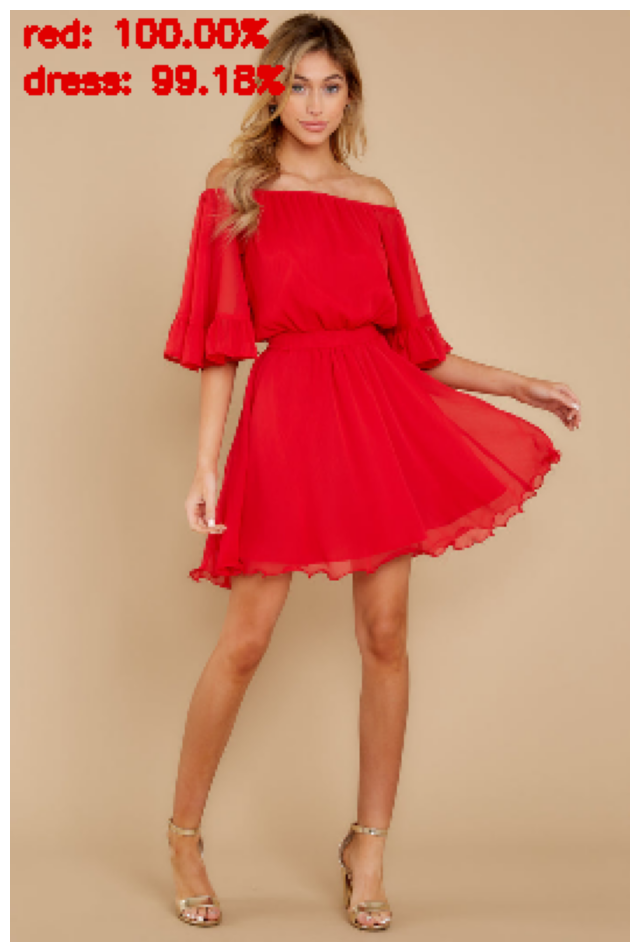

In [74]:
url = 'https://cdn.shopify.com/s/files/1/1708/7943/products/1-7-2010453_1024x1024.jpg?v=1578490466'
image = _downloadImage(url)
_predict_image(image, model, mlb)

1/1 [==============================] - 0s 45ms/step


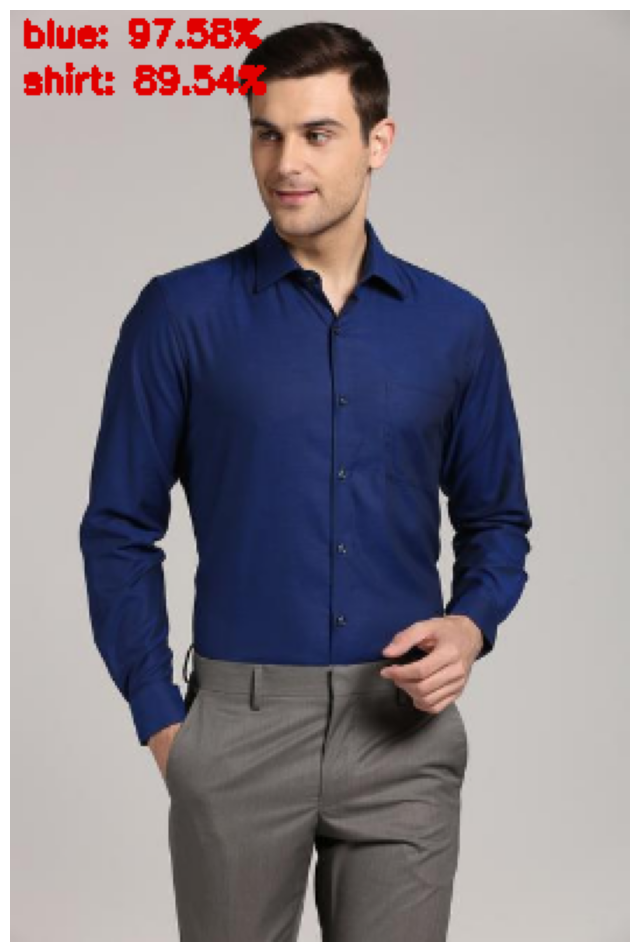

In [75]:
url = 'https://assets.abfrlcdn.com/img/app/product/3/317578-1475149-large.jpg'
image = _downloadImage(url)
_predict_image(image, model, mlb)

In [2]:
#Do not run the code below if you do not use google colab
# from google.colab import drive  #unmount drive
# drive.flush_and_unmount()